* In the name of God
* HW4 
* Amir Mohammad Yaghoobianzadeh

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

!pip install hazm
!pip install cleantext
!pip install transformers

import hazm
from cleantext import clean

import matplotlib.pyplot as plt
from torch.optim import Adam, SGD

from tqdm.notebook import tqdm
# from tqdm import tqdm

import os
import re
import json
import copy
import collections

from google.colab import drive
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive/Deep_learning/HW4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394485 sha256=feb96cd606de9ff7f2b9ab2ff68873632914dc4490e8715b3872141c42851289
  Stored in directory: /root/.cache/pip/wheels/19/1d/3a/0a8c14c30132b4f9ffd796efbb6746f15b3d6bcfc1055a9346
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp38-cp38-linux_x86_64.whl size=180557 sha256=38377f427c8e3d05d24844b90be3e746559fa1b3f1cf3fb19c95a17a541cda38
  Stored in directory: /root/.cache/pip/wheels/3c/d8/9f/59fd78b2b7d1e9ffcb68fb6de80c2e7c20b804c8cbc4d8fc23
Successfully built nltk libwapiti
  Attempting unin

# Data


In [2]:
# !git clone https://github.com/amnghd/Persian_poems_corpus


In [3]:
def write_my_text(txt):
    with open('q2.txt', 'w') as fp:
        for i in range(len(txt)):
            fp.write("%s\n" % txt[i])

            
def load_data(path):
    with open(path) as file:
        lines = [line.rstrip() for line in file]

    lines = lines[2:]

    normalizer = hazm.Normalizer()

    temp = [(lines[2*i] + ' '+ lines[2*i+1]).split() for i in range(len(lines)//2)]
    lines = [normalizer.normalize(lines[2*i] + ' '+ lines[2*i+1]) for i in range(len(lines)//2)]
    length_beyt = np.array([len(temp[i]) for i in range(len(temp))])

    print('#beyts: ', len(lines), 'min length:', length_beyt.min(), 'max length:', length_beyt.max())
    plt.hist(length_beyt, bins=np.arange(length_beyt.max()))
    plt.xlabel('length')
    plt.title(path)
    plt.show()
    
    return lines, length_beyt


def data_gl_than(data_length, less_than=100.0, greater_than=0.0):

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])
    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')
    

def remove_bad_beyts(beyts, length, minlim, maxlim):
    temp = []
    
    for i in range(len(beyts)):
        if length[i] > minlim and length[i] < maxlim:
            temp.append(beyts[i])
    
    return temp
    

label2id: {'ferdousi': 0, 'bahar': 1, 'sanaee': 2, 'bahaee': 3, 'hafez': 4, 'khayyam': 5, 'moulavi': 6, 'parvin': 7, 'shahriar': 8, 'saadi': 9}
id2label: {0: 'ferdousi', 1: 'bahar', 2: 'sanaee', 3: 'bahaee', 4: 'hafez', 5: 'khayyam', 6: 'moulavi', 7: 'parvin', 8: 'shahriar', 9: 'saadi'}

#beyts:  49608 min length: 5 max length: 20


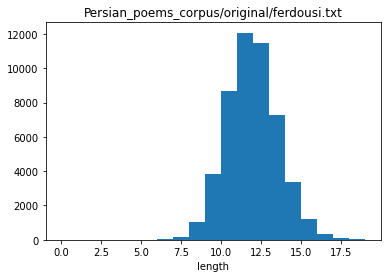

#beyts:  20932 min length: 0 max length: 24


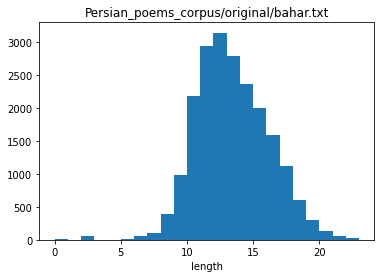

#beyts:  28856 min length: 0 max length: 26


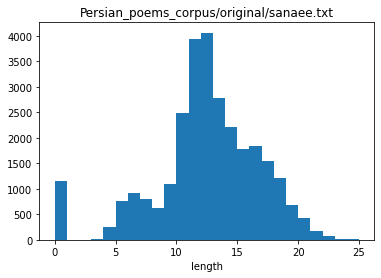

#beyts:  1406 min length: 4 max length: 22


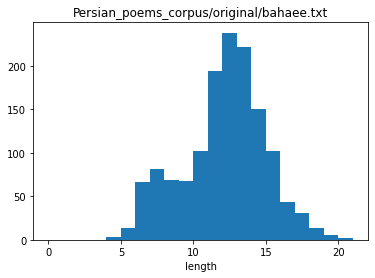

#beyts:  5113 min length: 0 max length: 24


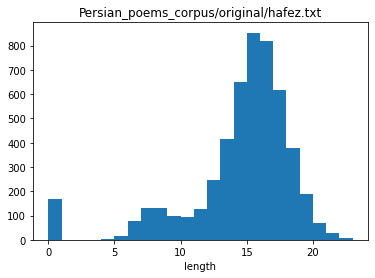

#beyts:  643 min length: 8 max length: 19


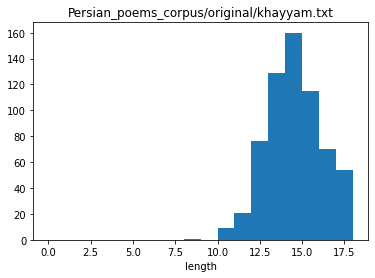

#beyts:  26655 min length: 0 max length: 24


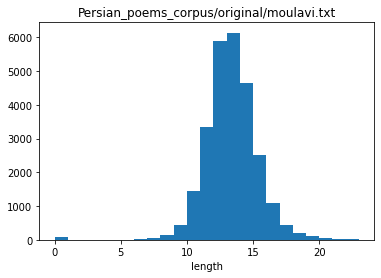

#beyts:  5809 min length: 0 max length: 22


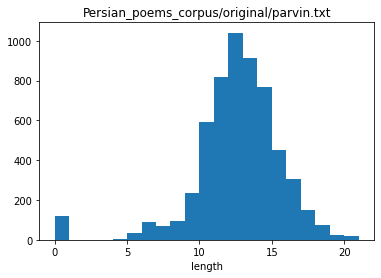

#beyts:  2044 min length: 0 max length: 29


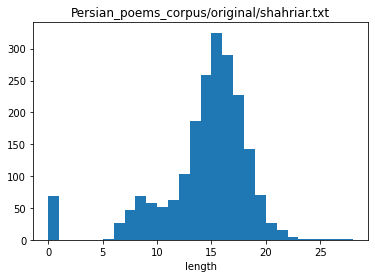

#beyts:  16459 min length: 0 max length: 26


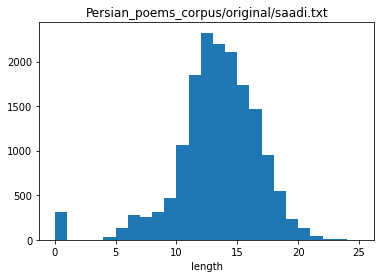

In [4]:
labels = ['ferdousi', 'bahar', 'sanaee', 'bahaee', 'hafez', 'khayyam', 'moulavi', 'parvin', 'shahriar', 'saadi']
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}\n')

poems = {}
poems_length = {}

for poet in labels:
  poems[poet], poems_length[poet] = load_data('Persian_poems_corpus/original/' + poet + '.txt')


In [5]:
minlim, maxlim = 2, 17

for poet in labels:
  data_gl_than(poems_length[poet], less_than=maxlim, greater_than=minlim)


Texts with word length of greater than 2 and less than 17 includes 99.96% of the whole!
Texts with word length of greater than 2 and less than 17 includes 94.13% of the whole!
Texts with word length of greater than 2 and less than 17 includes 86.91% of the whole!
Texts with word length of greater than 2 and less than 17 includes 98.44% of the whole!
Texts with word length of greater than 2 and less than 17 includes 83.55% of the whole!
Texts with word length of greater than 2 and less than 17 includes 96.11% of the whole!
Texts with word length of greater than 2 and less than 17 includes 98.11% of the whole!
Texts with word length of greater than 2 and less than 17 includes 96.01% of the whole!
Texts with word length of greater than 2 and less than 17 includes 83.41% of the whole!
Texts with word length of greater than 2 and less than 17 includes 92.18% of the whole!


In [6]:
for poet in labels:
  poems[poet] = remove_bad_beyts(poems[poet], poems_length[poet], minlim, maxlim)

data_x = []
data_y = []
label_weights = []

for poet in labels:
  data_x += poems[poet]

temp = len(data_x)

for poet in labels:
  label_weights.append(len(poems[poet]))
  data_y += [poet] * len(poems[poet])
  print(f'# {poet}: {len(poems[poet])}  ({len(poems[poet])/temp*100:.3f}%)')

print(f'\n# all samples: {temp}')

# ferdousi: 49499  (34.365%)
# bahar: 18584  (12.902%)
# sanaee: 23537  (16.341%)
# bahaee: 1353  (0.939%)
# hafez: 3654  (2.537%)
# khayyam: 581  (0.403%)
# moulavi: 25706  (17.847%)
# parvin: 5425  (3.766%)
# shahriar: 1477  (1.025%)
# saadi: 14223  (9.874%)

# all samples: 144039


In [7]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1, random_state=1, stratify=data_y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1, stratify=y_train)


# tokenizer

In [8]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [9]:
# general config
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

EPOCHS = 3
EEVERY_EPOCH = 500
LEARNING_RATE = 2e-3
CLIP = 0.0

MODEL_NAME = 'HooshvareLab/bert-fa-base-uncased'


In [10]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
config = BertConfig.from_pretrained(
    MODEL_NAME, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "ferdousi",
    "1": "bahar",
    "2": "sanaee",
    "3": "bahaee",
    "4": "hafez",
    "5": "khayyam",
    "6": "moulavi",
    "7": "parvin",
    "8": "shahriar",
    "9": "saadi"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "bahaee": 3,
    "bahar": 1,
    "ferdousi": 0,
    "hafez": 4,
    "khayyam": 5,
    "moulavi": 6,
    "parvin": 7,
    "saadi": 9,
    "sanaee": 2,
    "shahriar": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



In [11]:
tokens = tokenizer.tokenize(data_x[0])
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

   Tokens: به نام خداوند جان و خرد کزین برتر اندیشه برنگذرد
Token IDs: [2789, 2967, 6512, 3607, 1379, 4444, 27248, 2788, 5486, 7522, 28992, 7874, 2013]


# Dataset


In [12]:
class PoetryDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, beyts, targets=None, label_list=None, max_len=128):
        self.beyts = beyts
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.beyts)

    def __getitem__(self, item):
        beyt = str(self.beyts[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            beyt,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'beyt': beyt,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = PoetryDataset(
        beyts=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [13]:
train_data_loader = create_data_loader(x_train, y_train, tokenizer, maxlim, TRAIN_BATCH_SIZE, labels)
valid_data_loader = create_data_loader(x_valid, y_valid, tokenizer, maxlim, VALID_BATCH_SIZE, labels)
test_data_loader = create_data_loader(x_test, y_test, tokenizer, maxlim, TEST_BATCH_SIZE, labels)

In [14]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['beyt'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['beyt', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['نامهٔ خویشتن سیه کردی گفت روزی همی به رهگذری', 'که فرخ نژادی و فرخ سری ستون همه شهر و بوم و بری', 'کانچه ما در او بینیم سراسر به خطاست مدهش پند که بر بدمنشان پند هباست', 'ز لشکر برآمد سراسر خروش زمانه یکایک برآمد به جوش', 'پاس ملت را میان بستند و شد باری ز سیم کیسهٔ ملت تهی صندوق آنان ممتلی', 'تو در یک سال گویی یک قصیده چو توکاهل به شعر اندرکه دیده؟', 'این ثنا گفتن ز من ترک ثناست کین دلیل هستی و هستی خطاست', '* بر کوزه\u200cگری پریر کردم گذری، از خاک همی نمود هر دم هنری؛', 'بدین زودی اندر جهاندار شاه بیاید نشیند برین پیشگاه', 'سعدی اگر خون و مال صرف شود در وصال آنت مقامی بزرگ اینت بهایی حقیر', 'قفل سیمم بنزد سیمگر است پردهٔ اطلسم ببازار است', 'رنج مارست خفته بر سر گنج بشنو از بارگاه مصطفوی', ' سبب رحمت دو عالم اوست', 'خاص مشغول در نشیمن دین دین حق روی خود نهان کرده', 'سرانشان بخنجر ببرید پست بفتراک شبرنگ سرکش ببست', 'چو رفتی جهان جای دیگر کس است اگر هوشمندست وگر بی خرد', 'در گنج دینار او مهر کرد به ایوان 

# model

In [15]:
class PoetoryModel(nn.Module):

    def __init__(self, config):
        super(PoetoryModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        temp, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids,
            return_dict=False)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [16]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

### Training


In [17]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min



# Adam, freeze

In [ ]:
OUTPUT_PATH = 'pytorch_model, Adam, freeze.bin'

pt_model = PoetoryModel(config=config)
pt_model = pt_model.to(device)

for param in pt_model.parameters():
      param.requires_grad = False
for param in pt_model.classifier.parameters():
      param.requires_grad = True


Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
optimizer = Adam(pt_model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight= 1/torch.tensor(label_weights,device=device))

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)


Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 500...Train Loss: 2.028188...Train Acc: 0.299...Valid Loss: 1.926717...Valid Acc: 0.413...
Validation loss decreased (inf --> 1.926717).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1000...Train Loss: 1.953866...Train Acc: 0.328...Valid Loss: 1.800532...Valid Acc: 0.345...
Validation loss decreased (1.926717 --> 1.800532).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1500...Train Loss: 1.900993...Train Acc: 0.346...Valid Loss: 1.776090...Valid Acc: 0.393...
Validation loss decreased (1.800532 --> 1.776090).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2000...Train Loss: 1.857879...Train Acc: 0.359...Valid Loss: 1.770443...Valid Acc: 0.328...
Validation loss decreased (1.776090 --> 1.770443).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2500...Train Loss: 1.789669...Train Acc: 0.387...Valid Loss: 1.753181...Valid Acc: 0.400...
Validation loss decreased (1.770443 --> 1.753181).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 3000...Train Loss: 1.753841...Train Acc: 0.396...Valid Loss: 1.739025...Valid Acc: 0.367...
Validation loss decreased (1.753181 --> 1.739025).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 3500...Train Loss: 1.730115...Train Acc: 0.401...Valid Loss: 1.772880...Valid Acc: 0.372...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 4000...Train Loss: 1.828670...Train Acc: 0.363...Valid Loss: 1.713696...Valid Acc: 0.459...
Validation loss decreased (1.739025 --> 1.713696).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 4500...Train Loss: 1.733743...Train Acc: 0.395...Valid Loss: 1.692877...Valid Acc: 0.409...
Validation loss decreased (1.713696 --> 1.692877).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 5000...Train Loss: 1.691023...Train Acc: 0.409...Valid Loss: 1.684227...Valid Acc: 0.446...
Validation loss decreased (1.692877 --> 1.684227).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

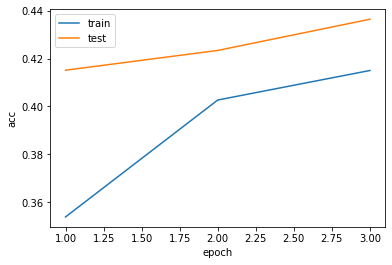

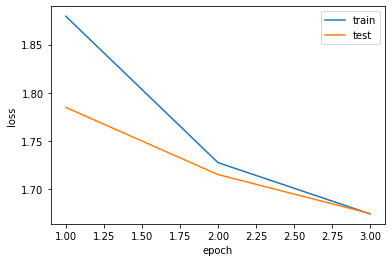

In [ ]:
plt.plot(np.arange(1, EPOCHS + 1), history['train_acc'])
plt.plot(np.arange(1, EPOCHS + 1), history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'test'])
plt.show()

plt.plot(np.arange(1, EPOCHS + 1), history['train_loss'])
plt.plot(np.arange(1, EPOCHS + 1), history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()



# SGD, freeze

In [ ]:
OUTPUT_PATH = 'pytorch_model, SGD, freeze.bin'

pt_model = PoetoryModel(config=config)
pt_model = pt_model.to(device)

for param in pt_model.parameters():
      param.requires_grad = False
for param in pt_model.classifier.parameters():
      param.requires_grad = True


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = SGD(pt_model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight= 1/torch.tensor(label_weights,device=device))

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)


Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 500...Train Loss: 2.234669...Train Acc: 0.060...Valid Loss: 2.192163...Valid Acc: 0.021...
Validation loss decreased (inf --> 2.192163).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1000...Train Loss: 2.200352...Train Acc: 0.060...Valid Loss: 2.139405...Valid Acc: 0.050...
Validation loss decreased (2.192163 --> 2.139405).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1500...Train Loss: 2.171982...Train Acc: 0.065...Valid Loss: 2.111674...Valid Acc: 0.071...
Validation loss decreased (2.139405 --> 2.111674).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2000...Train Loss: 2.124706...Train Acc: 0.109...Valid Loss: 2.089428...Valid Acc: 0.133...
Validation loss decreased (2.111674 --> 2.089428).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2500...Train Loss: 2.095853...Train Acc: 0.139...Valid Loss: 2.078444...Valid Acc: 0.154...
Validation loss decreased (2.089428 --> 2.078444).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 3000...Train Loss: 2.077246...Train Acc: 0.147...Valid Loss: 2.056353...Valid Acc: 0.148...
Validation loss decreased (2.078444 --> 2.056353).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 3500...Train Loss: 2.064838...Train Acc: 0.156...Valid Loss: 2.054614...Valid Acc: 0.141...
Validation loss decreased (2.056353 --> 2.054614).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 4000...Train Loss: 2.073326...Train Acc: 0.171...Valid Loss: 2.045109...Valid Acc: 0.235...
Validation loss decreased (2.054614 --> 2.045109).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 4500...Train Loss: 2.051658...Train Acc: 0.188...Valid Loss: 2.037417...Valid Acc: 0.201...
Validation loss decreased (2.045109 --> 2.037417).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 5000...Train Loss: 2.035911...Train Acc: 0.191...Valid Loss: 2.031326...Valid Acc: 0.196...
Validation loss decreased (2.037417 --> 2.031326).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

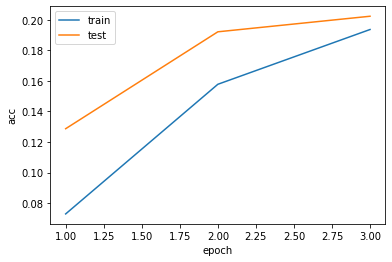

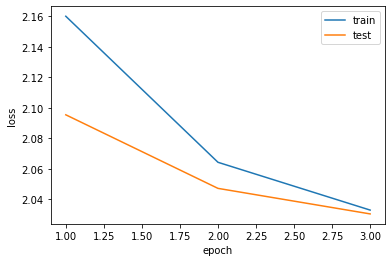

In [ ]:
plt.plot(np.arange(1, EPOCHS + 1), history['train_acc'])
plt.plot(np.arange(1, EPOCHS + 1), history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'test'])
plt.show()

plt.plot(np.arange(1, EPOCHS + 1), history['train_loss'])
plt.plot(np.arange(1, EPOCHS + 1), history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()



# Adam, train all the network

In [ ]:
OUTPUT_PATH = 'pytorch_model, Adam, all.bin'

pt_model = PoetoryModel(config=config)
pt_model = pt_model.to(device)

for param in pt_model.parameters():
      param.requires_grad = True


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = Adam(pt_model.parameters(), lr=LEARNING_RATE/100)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight= 1/torch.tensor(label_weights,device=device))

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)


Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 500...Train Loss: 1.810309...Train Acc: 0.365...Valid Loss: 1.506383...Valid Acc: 0.528...
Validation loss decreased (inf --> 1.506383).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1000...Train Loss: 1.595265...Train Acc: 0.458...Valid Loss: 1.256362...Valid Acc: 0.582...
Validation loss decreased (1.506383 --> 1.256362).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1500...Train Loss: 1.454435...Train Acc: 0.513...Valid Loss: 1.151429...Valid Acc: 0.642...
Validation loss decreased (1.256362 --> 1.151429).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2000...Train Loss: 1.024907...Train Acc: 0.666...Valid Loss: 1.078768...Valid Acc: 0.681...
Validation loss decreased (1.151429 --> 1.078768).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2500...Train Loss: 0.879450...Train Acc: 0.700...Valid Loss: 1.076377...Valid Acc: 0.680...
Validation loss decreased (1.078768 --> 1.076377).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 3000...Train Loss: 0.765211...Train Acc: 0.728...Valid Loss: 1.059295...Valid Acc: 0.686...
Validation loss decreased (1.076377 --> 1.059295).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 3500...Train Loss: 0.697172...Train Acc: 0.744...Valid Loss: 1.064623...Valid Acc: 0.717...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 4000...Train Loss: 0.585114...Train Acc: 0.768...Valid Loss: 1.109388...Valid Acc: 0.728...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 4500...Train Loss: 0.449532...Train Acc: 0.808...Valid Loss: 1.155092...Valid Acc: 0.753...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 5000...Train Loss: 0.384405...Train Acc: 0.829...Valid Loss: 1.221356...Valid Acc: 0.756...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

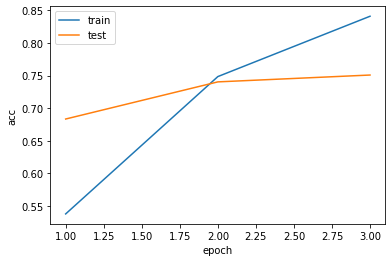

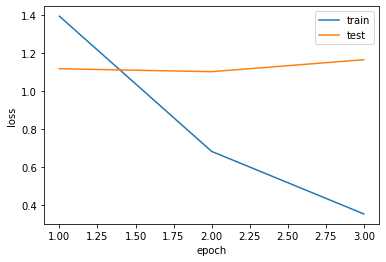

In [ ]:
plt.plot(np.arange(1, EPOCHS + 1), history['train_acc'])
plt.plot(np.arange(1, EPOCHS + 1), history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'test'])
plt.show()

plt.plot(np.arange(1, EPOCHS + 1), history['train_loss'])
plt.plot(np.arange(1, EPOCHS + 1), history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()



# SGD, train all the network

In [ ]:
OUTPUT_PATH = 'pytorch_model, SGD, all.bin'

pt_model = PoetoryModel(config=config)
pt_model = pt_model.to(device)

for param in pt_model.parameters():
      param.requires_grad = True


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = SGD(pt_model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight= 1/torch.tensor(label_weights,device=device))

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)


Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 500...Train Loss: 2.141060...Train Acc: 0.148...Valid Loss: 1.983911...Valid Acc: 0.193...
Validation loss decreased (inf --> 1.983911).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1000...Train Loss: 1.975993...Train Acc: 0.246...Valid Loss: 1.658258...Valid Acc: 0.385...
Validation loss decreased (1.983911 --> 1.658258).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1500...Train Loss: 1.855941...Train Acc: 0.302...Valid Loss: 1.568601...Valid Acc: 0.409...
Validation loss decreased (1.658258 --> 1.568601).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2000...Train Loss: 1.585865...Train Acc: 0.440...Valid Loss: 1.521182...Valid Acc: 0.494...
Validation loss decreased (1.568601 --> 1.521182).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2500...Train Loss: 1.492289...Train Acc: 0.469...Valid Loss: 1.471857...Valid Acc: 0.529...
Validation loss decreased (1.521182 --> 1.471857).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 3000...Train Loss: 1.409084...Train Acc: 0.486...Valid Loss: 1.354570...Valid Acc: 0.519...
Validation loss decreased (1.471857 --> 1.354570).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 2/3...Step: 3500...Train Loss: 1.362047...Train Acc: 0.500...Valid Loss: 1.409626...Valid Acc: 0.548...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Training... :   0%|          | 0/1823 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 4000...Train Loss: 1.340286...Train Acc: 0.517...Valid Loss: 1.318516...Valid Acc: 0.521...
Validation loss decreased (1.354570 --> 1.318516).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 4500...Train Loss: 1.225598...Train Acc: 0.540...Valid Loss: 1.316809...Valid Acc: 0.539...
Validation loss decreased (1.318516 --> 1.316809).  Saving model ...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 3/3...Step: 5000...Train Loss: 1.160035...Train Acc: 0.554...Valid Loss: 1.331656...Valid Acc: 0.593...


Evaluation... :   0%|          | 0/203 [00:00<?, ?it/s]

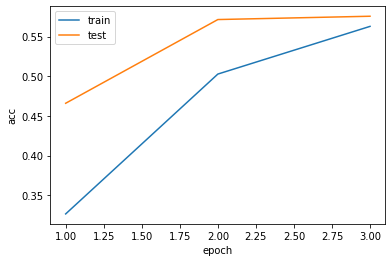

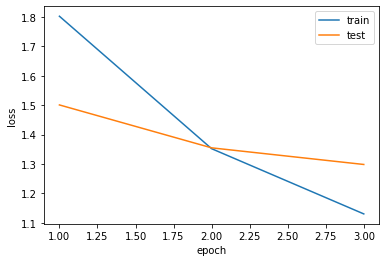

In [ ]:
plt.plot(np.arange(1, EPOCHS + 1), history['train_acc'])
plt.plot(np.arange(1, EPOCHS + 1), history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'test'])
plt.show()

plt.plot(np.arange(1, EPOCHS + 1), history['train_loss'])
plt.plot(np.arange(1, EPOCHS + 1), history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()



# Prediction

In [18]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs


In [19]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
import pandas as pd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 11.4 MB/s eta 0:00:00


In [20]:
y_test = [labels.index(label) for label in y_test]

In [ ]:
# 'pytorch_model, SGD, freeze.bin'
pt_model = PoetoryModel(config=config).to(device)
pt_model.load_state_dict(torch.load('pytorch_model, SGD, freeze.bin'))

preds, probs = predict(pt_model, x_test, tokenizer, max_len=maxlim)

print(f'F1: {f1_score(y_test, preds, average="weighted")}')
print()
print(classification_report(y_test, preds, target_names=labels))

confmat = ConfusionMatrix(task="multiclass", num_classes=10, normalize='true')
CM = confmat(torch.tensor(preds), torch.tensor(y_test))

data = {labels[i]: CM[:,i] for i in range(len(labels))}
df = pd.DataFrame(data, index=labels)
display(df)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/451 [00:00<?, ?it/s]

F1: 0.21309455421109852

              precision    recall  f1-score   support

    ferdousi       0.83      0.28      0.41      4950
       bahar       0.24      0.08      0.12      1858
      sanaee       0.21      0.41      0.28      2354
      bahaee       0.00      0.00      0.00       135
       hafez       0.05      0.67      0.09       365
     khayyam       0.00      0.00      0.00        58
     moulavi       0.53      0.01      0.01      2571
      parvin       0.58      0.06      0.11       543
    shahriar       0.03      0.41      0.05       148
       saadi       0.06      0.00      0.00      1422

    accuracy                           0.20     14404
   macro avg       0.25      0.19      0.11     14404
weighted avg       0.48      0.20      0.21     14404



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,ferdousi,bahar,sanaee,bahaee,hafez,khayyam,moulavi,parvin,shahriar,saadi
ferdousi,0.276162,0.061212,0.317374,0.000000,0.258384,0.0,0.001010,0.000202,0.083232,0.002424
bahar,0.033907,0.082347,0.275565,0.001076,0.358450,0.0,0.003229,0.003767,0.238428,0.003229
sanaee,0.018267,0.023364,0.405692,0.000000,0.400595,0.0,0.000850,0.001699,0.147409,0.002124
bahaee,0.022222,0.022222,0.296296,0.000000,0.466667,0.0,0.000000,0.014815,0.177778,0.000000
hafez,0.010959,0.005479,0.134247,0.000000,0.673973,0.0,0.000000,0.002740,0.169863,0.002740
khayyam,0.000000,0.051724,0.241379,0.000000,0.431034,0.0,0.000000,0.017241,0.258621,0.000000
moulavi,0.035784,0.029949,0.398678,0.000000,0.355115,0.0,0.007001,0.001945,0.170362,0.001167
parvin,0.040516,0.018416,0.233886,0.000000,0.377532,0.0,0.001842,0.060773,0.263352,0.003683
shahriar,0.000000,0.013514,0.074324,0.000000,0.500000,0.0,0.000000,0.000000,0.412162,0.000000
saadi,0.030942,0.021800,0.193390,0.000000,0.575949,0.0,0.001406,0.002110,0.172996,0.001406


In [ ]:
# 'pytorch_model, SGD, all.bin'
pt_model = PoetoryModel(config=config).to(device)
pt_model.load_state_dict(torch.load('pytorch_model, SGD, all.bin'))

preds, probs = predict(pt_model, x_test, tokenizer, max_len=maxlim)

print(f'F1: {f1_score(y_test, preds, average="weighted")}')
print()
print(classification_report(y_test, preds, target_names=labels))

confmat = ConfusionMatrix(task="multiclass", num_classes=10, normalize='true')
CM = confmat(torch.tensor(preds), torch.tensor(y_test))

data = {labels[i]: CM[:,i] for i in range(len(labels))}
df = pd.DataFrame(data, index=labels)
display(df)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/451 [00:00<?, ?it/s]

F1: 0.5560066730888935

              precision    recall  f1-score   support

    ferdousi       0.94      0.75      0.83      4950
       bahar       0.45      0.31      0.37      1858
      sanaee       0.40      0.65      0.49      2354
      bahaee       0.18      0.54      0.27       135
       hafez       0.18      0.71      0.28       365
     khayyam       0.10      0.62      0.17        58
     moulavi       0.72      0.29      0.41      2571
      parvin       0.47      0.48      0.47       543
    shahriar       0.28      0.52      0.37       148
       saadi       0.38      0.35      0.36      1422

    accuracy                           0.54     14404
   macro avg       0.41      0.52      0.40     14404
weighted avg       0.64      0.54      0.56     14404



,ferdousi,bahar,sanaee,bahaee,hafez,khayyam,moulavi,parvin,shahriar,saadi
ferdousi,0.749091,0.070101,0.084646,0.000000,0.004646,0.011515,0.011515,0.009697,0.002424,0.056364
bahar,0.046825,0.309473,0.227664,0.056512,0.120022,0.024220,0.035522,0.062433,0.026911,0.090420
sanaee,0.014868,0.048003,0.646134,0.023789,0.120646,0.013594,0.050977,0.006797,0.008496,0.066695
bahaee,0.000000,0.014815,0.192593,0.540741,0.066667,0.007407,0.000000,0.096296,0.007407,0.074074
hafez,0.000000,0.016438,0.082192,0.008219,0.709589,0.024658,0.005479,0.002740,0.076712,0.073973
khayyam,0.034483,0.017241,0.034483,0.000000,0.120690,0.620690,0.034483,0.017241,0.051724,0.068966
moulavi,0.017892,0.047841,0.416958,0.028394,0.072345,0.035395,0.285492,0.026449,0.010502,0.058732
parvin,0.027624,0.053407,0.130755,0.071823,0.055249,0.084715,0.033149,0.480663,0.007366,0.055249
shahriar,0.000000,0.033784,0.027027,0.000000,0.351351,0.027027,0.000000,0.006757,0.520270,0.033784
saadi,0.030239,0.045710,0.161041,0.045007,0.267229,0.023207,0.015471,0.024613,0.035162,0.352321


In [ ]:
# 'pytorch_model, Adam, freeze.bin'
pt_model = PoetoryModel(config=config).to(device)
pt_model.load_state_dict(torch.load('pytorch_model, Adam, freeze.bin'))

preds, probs = predict(pt_model, x_test, tokenizer, max_len=maxlim)

print(f'F1: {f1_score(y_test, preds, average="weighted")}')
print()
print(classification_report(y_test, preds, target_names=labels))

confmat = ConfusionMatrix(task="multiclass", num_classes=10, normalize='true')
CM = confmat(torch.tensor(preds), torch.tensor(y_test))

data = {labels[i]: CM[:,i] for i in range(len(labels))}
df = pd.DataFrame(data, index=labels)
display(df)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/451 [00:00<?, ?it/s]

F1: 0.47370714191662505

              precision    recall  f1-score   support

    ferdousi       0.84      0.69      0.76      4950
       bahar       0.43      0.21      0.28      1858
      sanaee       0.36      0.49      0.42      2354
      bahaee       0.17      0.35      0.23       135
       hafez       0.09      0.65      0.16       365
     khayyam       0.18      0.17      0.18        58
     moulavi       0.63      0.24      0.34      2571
      parvin       0.32      0.49      0.39       543
    shahriar       0.07      0.40      0.12       148
       saadi       0.37      0.17      0.23      1422

    accuracy                           0.45     14404
   macro avg       0.35      0.39      0.31     14404
weighted avg       0.57      0.45      0.47     14404



,ferdousi,bahar,sanaee,bahaee,hafez,khayyam,moulavi,parvin,shahriar,saadi
ferdousi,0.693535,0.045859,0.104646,0.000404,0.065253,0.001212,0.018182,0.026869,0.021212,0.022828
bahar,0.103875,0.209903,0.207212,0.033369,0.189989,0.004306,0.041981,0.075888,0.088267,0.045210
sanaee,0.066695,0.041206,0.493203,0.017842,0.196262,0.002124,0.053526,0.032285,0.057349,0.039507
bahaee,0.014815,0.022222,0.155556,0.348148,0.177778,0.000000,0.044444,0.140741,0.051852,0.044444
hafez,0.008219,0.024658,0.112329,0.002740,0.652055,0.002740,0.016438,0.016438,0.120548,0.043836
khayyam,0.051724,0.000000,0.120690,0.051724,0.241379,0.172414,0.068966,0.155172,0.068966,0.068966
moulavi,0.057954,0.035395,0.303773,0.014391,0.204590,0.004667,0.238040,0.041618,0.065344,0.034228
parvin,0.053407,0.033149,0.116022,0.055249,0.110497,0.016575,0.033149,0.491713,0.069982,0.020258
shahriar,0.020270,0.040541,0.081081,0.006757,0.385135,0.000000,0.000000,0.027027,0.398649,0.040541
saadi,0.064698,0.040084,0.168073,0.030942,0.360056,0.002813,0.027426,0.045710,0.089311,0.170886


In [ ]:
# 'pytorch_model, Adam, all.bin'
pt_model = PoetoryModel(config=config).to(device)
pt_model.load_state_dict(torch.load('pytorch_model, Adam, all.bin'))

preds, probs = predict(pt_model, x_test, tokenizer, max_len=maxlim)

print(f'F1: {f1_score(y_test, preds, average="weighted")}')
print()
print(classification_report(y_test, preds, target_names=labels))

confmat = ConfusionMatrix(task="multiclass", num_classes=10, normalize='true')
CM = confmat(torch.tensor(preds), torch.tensor(y_test))

data = {labels[i]: CM[:,i] for i in range(len(labels))}
df = pd.DataFrame(data, index=labels)
display(df)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/451 [00:00<?, ?it/s]

F1: 0.7066004799538859

              precision    recall  f1-score   support

    ferdousi       0.98      0.85      0.91      4950
       bahar       0.56      0.62      0.59      1858
      sanaee       0.62      0.63      0.63      2354
      bahaee       0.21      0.56      0.31       135
       hafez       0.28      0.73      0.40       365
     khayyam       0.26      0.69      0.38        58
     moulavi       0.85      0.55      0.66      2571
      parvin       0.57      0.67      0.62       543
    shahriar       0.44      0.59      0.50       148
       saadi       0.49      0.60      0.54      1422

    accuracy                           0.69     14404
   macro avg       0.53      0.65      0.55     14404
weighted avg       0.75      0.69      0.71     14404



,ferdousi,bahar,sanaee,bahaee,hafez,khayyam,moulavi,parvin,shahriar,saadi
ferdousi,0.848283,0.073131,0.020808,0.000000,0.000808,0.001616,0.003636,0.007475,0.000000,0.044242
bahar,0.016146,0.620022,0.090958,0.026911,0.057589,0.005382,0.032293,0.048977,0.015070,0.086652
sanaee,0.005947,0.075191,0.632965,0.035259,0.063721,0.007647,0.056075,0.017842,0.005947,0.099405
bahaee,0.000000,0.051852,0.111111,0.555556,0.037037,0.007407,0.022222,0.081481,0.022222,0.111111
hafez,0.000000,0.043836,0.054795,0.002740,0.728767,0.010959,0.002740,0.008219,0.049315,0.098630
khayyam,0.000000,0.017241,0.017241,0.000000,0.137931,0.689655,0.068966,0.000000,0.034483,0.034483
moulavi,0.003890,0.075457,0.175029,0.035395,0.053287,0.016725,0.545313,0.024115,0.006223,0.064566
parvin,0.007366,0.086556,0.040516,0.036832,0.034991,0.034991,0.018416,0.674033,0.011050,0.055249
shahriar,0.000000,0.067568,0.013514,0.013514,0.243243,0.000000,0.000000,0.000000,0.594595,0.067568
saadi,0.014065,0.063994,0.078762,0.023910,0.160338,0.006329,0.015471,0.018284,0.018987,0.599859


# perplexity

In [21]:
def perplexity(test_data_loader, model):
  perplexity = 0
  length = 0
  model.eval()
  with torch.no_grad():
    for dl in tqdm(test_data_loader, total=len(test_data_loader)):

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # # clear the gradients of all optimized variables
        # optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        
        prob, preds = torch.max(outputs, dim=1)
        # print(prob, preds)
        # calculate the batch loss
        # loss = loss_fn(outputs, targets)

        perplexity += torch.log(prob).sum()
        length += outputs.shape[0]

  return torch.exp(-perplexity/length)


pt_model = PoetoryModel(config=config).to(device)
print('perplexity before fine tune:', perplexity(test_data_loader, pt_model))

pt_model.load_state_dict(torch.load('pytorch_model, Adam, all.bin'))
print('perplexityafter fine tune:', perplexity(test_data_loader, pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/226 [00:00<?, ?it/s]

perplexity before fine tune: tensor(2.1171)


  0%|          | 0/226 [00:00<?, ?it/s]

perplexityafter fine tune: tensor(0.2377)
